In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


# Additional imports

In [3]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Preprocessing

In [4]:
train_data_raw = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data_raw = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

print('train_data_shape: ' + str(train_data_raw.shape))
print('test_data_shape: ' + str(test_data_raw.shape))

train_data_shape: (42000, 785)
test_data_shape: (28000, 784)


### Shuffle

In [5]:
train_data_shuffled = train_data_raw.sample(frac=1)

train_data_shuffled

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
35025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32815,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12224,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14115,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14323,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25855,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10825,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11636,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split

In [6]:
def split_data(data, split=0.8):
    split_size = int(data.shape[0] * split)
    
    train_data = data[:split_size]
    val_data = data[split_size:]
    
    return train_data, val_data


train_data, val_data = split_data(train_data_shuffled)

print('train_data_shape: ' + str(train_data.shape))
print('val_data_shape: ' + str(val_data.shape))


train_data_shape: (33600, 785)
val_data_shape: (8400, 785)


### Pre processing data

In [7]:
def pre_process_data(dataset, has_label=True):
    if has_label:
        data = dataset.iloc[:,1:].values
    else:
        data = dataset.iloc[:,:].values
        
    data = data.astype(np.float)
    
    data = np.multiply(data, 1.0 / 255.0)
        
    return data

train_images = pre_process_data(train_data)
val_images = pre_process_data(val_data)
train_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Pre processing labels

In [8]:
def pre_process_labels(data):
    labels_flat = data.iloc[:,0].values.ravel()
    num_classes = np.unique(labels_flat).shape[0]
    
    num_labels = labels_flat.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_flat.ravel()] = 1

    return labels_one_hot.astype(np.uint8)

train_labels = pre_process_labels(train_data)
val_labels = pre_process_labels(val_data)

print("shape: " + str(train_labels.shape))
print(train_labels)

shape: (33600, 10)
[[1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]]


# Showing data

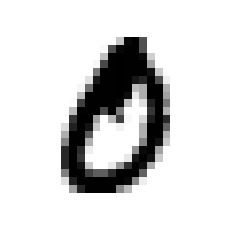

In [9]:
image_size = train_images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width, image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

display(train_images[7])

# Model

In [10]:
print(train_images.shape)
print(train_labels.shape)

(33600, 784)
(33600, 10)


In [11]:
model = keras.Sequential([
    keras.layers.Input(shape=(784,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='swish'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='swish'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='swish'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='swish'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['accuracy'])

In [12]:
print("Train images shape: " + str(train_images.shape))
print("Train labels shape: " + str(train_labels.shape))
print("Validation images shape: " + str(val_images.shape))
print("Validation labels shape: " + str(val_labels.shape))

Train images shape: (33600, 784)
Train labels shape: (33600, 10)
Validation images shape: (8400, 784)
Validation labels shape: (8400, 10)


In [13]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

hist = model.fit(x=train_images, y=train_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_steps=10, validation_data=(val_images, val_labels))
# , validation_steps=10, validation_data=(val_images, val_labels)

Epoch 1/20
1050/1050 [==============================] - 7s 7ms/step - loss: 0.0320 - accuracy: 0.8501 - val_loss: 0.0141 - val_accuracy: 0.9250
Epoch 2/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0125 - accuracy: 0.9350 - val_loss: 0.0112 - val_accuracy: 0.9281
Epoch 3/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0101 - accuracy: 0.9454 - val_loss: 0.0073 - val_accuracy: 0.9656
Epoch 4/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0087 - accuracy: 0.9530 - val_loss: 0.0082 - val_accuracy: 0.9469
Epoch 5/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0079 - accuracy: 0.9575 - val_loss: 0.0084 - val_accuracy: 0.9531
Epoch 6/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0068 - accuracy: 0.9625 - val_loss: 0.0085 - val_accuracy: 0.9500
Epoch 7/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0067 - accuracy: 0.9629 - val_loss: 0.0078 - val_accuracy:

# Predicting

In [18]:
test_data = pre_process_data(test_data_raw, False)

test_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
predictions = model.predict(test_data)

In [20]:
predictions

array([[-5.5649690e-04,  8.7698922e-04,  9.9012721e-01, ...,
        -7.7178851e-03,  9.5683821e-03, -3.6745481e-03],
       [ 9.4815040e-01,  6.0891882e-03, -9.7096115e-03, ...,
        -5.4179728e-03,  1.8641125e-02, -1.7097350e-03],
       [-5.7344548e-03, -4.0953197e-03, -1.7504096e-03, ...,
         5.7920665e-03, -3.4089610e-03,  9.8776317e-01],
       ...,
       [-5.5085868e-04,  6.2603503e-05, -1.2009576e-02, ...,
        -1.2235239e-02, -4.8783422e-04, -4.1662343e-03],
       [-6.3115694e-03, -3.5184100e-03, -2.5578514e-03, ...,
         5.7573840e-03, -4.7882311e-03,  9.8890513e-01],
       [-2.1760352e-04,  7.7659637e-04,  9.9000299e-01, ...,
        -7.7491626e-03,  9.7495839e-03, -3.5826610e-03]], dtype=float32)

In [21]:
# submissions for Kaggle
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": np.argmax(predictions, axis=1)})
submissions.to_csv("my_submissions.csv", index=False, header=True)